# Imports

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from sklearn import linear_model as lm
import scikitplot as skplt
pd.options.mode.chained_assignment = None  # default='warn'

# helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [4]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [5]:
def performace(model_name,data,y_val,yhat_class,k):
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val,yhat_class)
    recal = sklearn.metrics.recall_score(y_val,yhat_class)
    recal_k = recall_at_k(data,k)
    prec_k = precision_at_k(data,k)
    
    return pd.DataFrame({'Model Name':model_name,
                        'Precison':prec,
                        'Recall':recal,
                        'k':k,
                        'Precison at k':prec_k,
                        'Recall at k':recal_k},index=[0])

In [61]:
def performace_cross_val(data,target,model,model_name,round_n=3,splits=4,shuffle_n=True,random=42,k=2000):
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits,shuffle=shuffle_n,random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target,'id'])
    precision = []
    recall = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X,y):
        #train the model 
        model.fit(X.iloc[train_index],y.iloc[train_index])

        #predict the classification 
        yhat_class = model.predict( X.iloc[test_index] )

        #predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index],yhat_class)
        rec = sklearn.metrics.recall_score(y.iloc[test_index],yhat_class)
        precision.append(prec)
        recall.append(rec)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y[test_index]
        aux['score'] = yhat_proba[:,1].tolist()

        # sorte by score
        aux = aux.sort_values('score',ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux,k))
        rec_k.append(recall_at_k(aux,k))

    # return a dataset with the metrics    
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                                'PRECISION CROSS_VAL': np.round( np.mean( precision ), round_n ),
                                'PRECISON STD': np.round( np.std( precision ), round_n ),
                                'RECALL CROSS_VAL': np.round( np.mean( recall ), round_n ),
                                'RECALL STD': np.round( np.std( recall ), round_n ),
                                'PRECISION AT K CROSS_VAL': np.round( np.mean( prec_k ), round_n ),
                                'PRECISION AT K STD': np.round( np.std( prec_k ), round_n ),
                                'RECALL AT K CROSS_VAL': np.round( np.mean( rec_k), round_n ),
                                'RECALL AT K STD': np.round( np.std( rec_k )) },index=[0]) 

# Load data

In [6]:
df6 = pd.read_csv('data/df5.csv')

In [7]:
df6.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response
0,1,0.369231,28.0,26.0,0,0.716263,3,1,1
1,2,0.861538,3.0,26.0,0,0.598616,2,0,0
2,3,0.415385,28.0,26.0,0,0.058824,3,1,1
3,4,0.015385,11.0,152.0,1,0.667820,1,0,0
4,5,0.138462,41.0,152.0,1,0.100346,1,0,0


In [8]:
df6.dtypes

id                        int64
age                     float64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
vintage                 float64
vehicle_age               int64
vehicle_damage            int64
response                  int64
dtype: object

## Slipt train test

In [9]:
from sklearn.model_selection import StratifiedKFold

In [10]:
train, val = train_test_split(df6,test_size=0.3,stratify=df6['response'],random_state=42)

# train dataframes
X_train = train.copy()
y_train = X_train['response']
X_train.drop(columns = ['response','id'],inplace=True)
# validation dataframes
x_val = val.copy()
y_val = val['response']
x_val.drop(columns = ['response','id'],inplace=True)

# Machine learning

## KNN

In [11]:
#model
knn_model = KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [12]:
#model prediction proba - poder de generalizção
yhat_knn_proba = knn_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_knn_class = knn_model.predict( x_val )

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


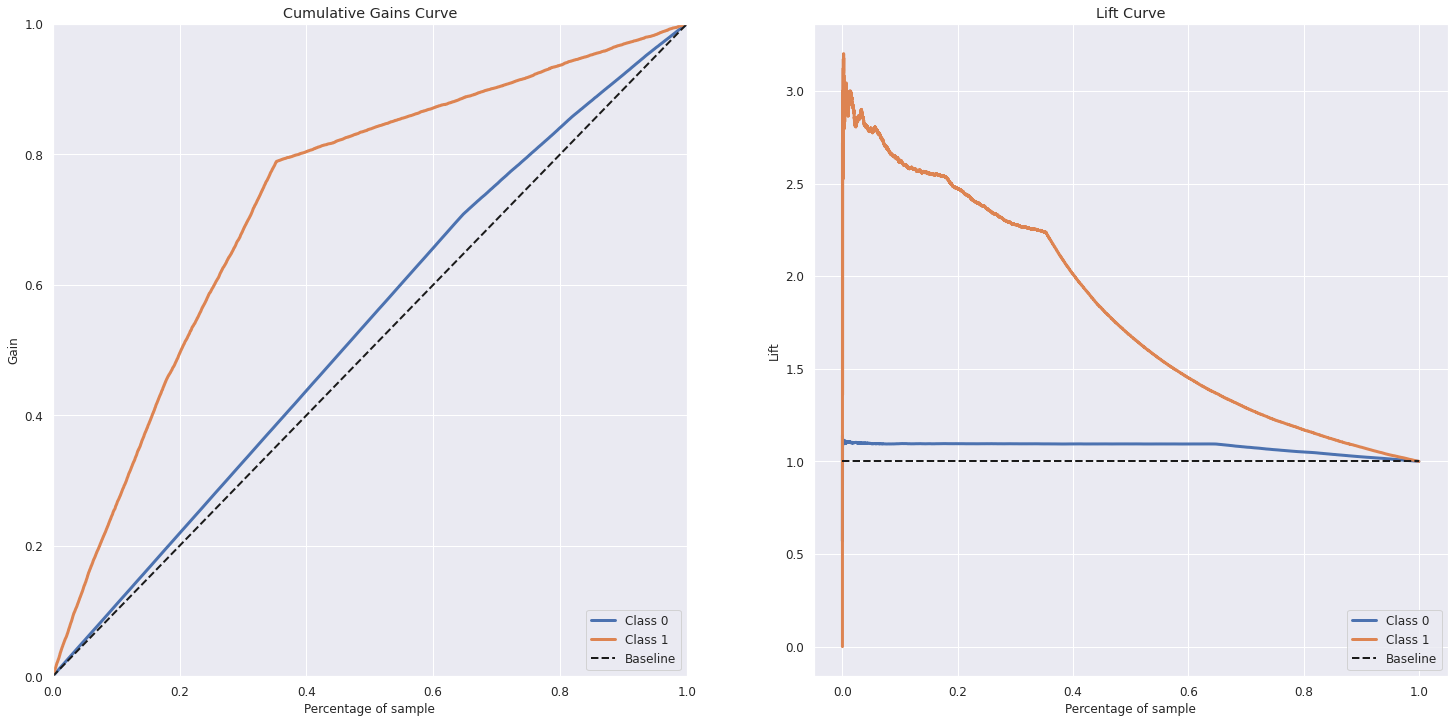

In [13]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_knn_proba,ax=ax[1]);

## Linear model

In [14]:
lm_model = lm.LogisticRegression(random_state=42,n_jobs=-1)
lm_model.fit(X_train,y_train)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=42)

In [15]:
#model prediction proba - poder de generalizção
yhat_lm_proba = lm_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_lm_class = lm_model.predict( x_val )

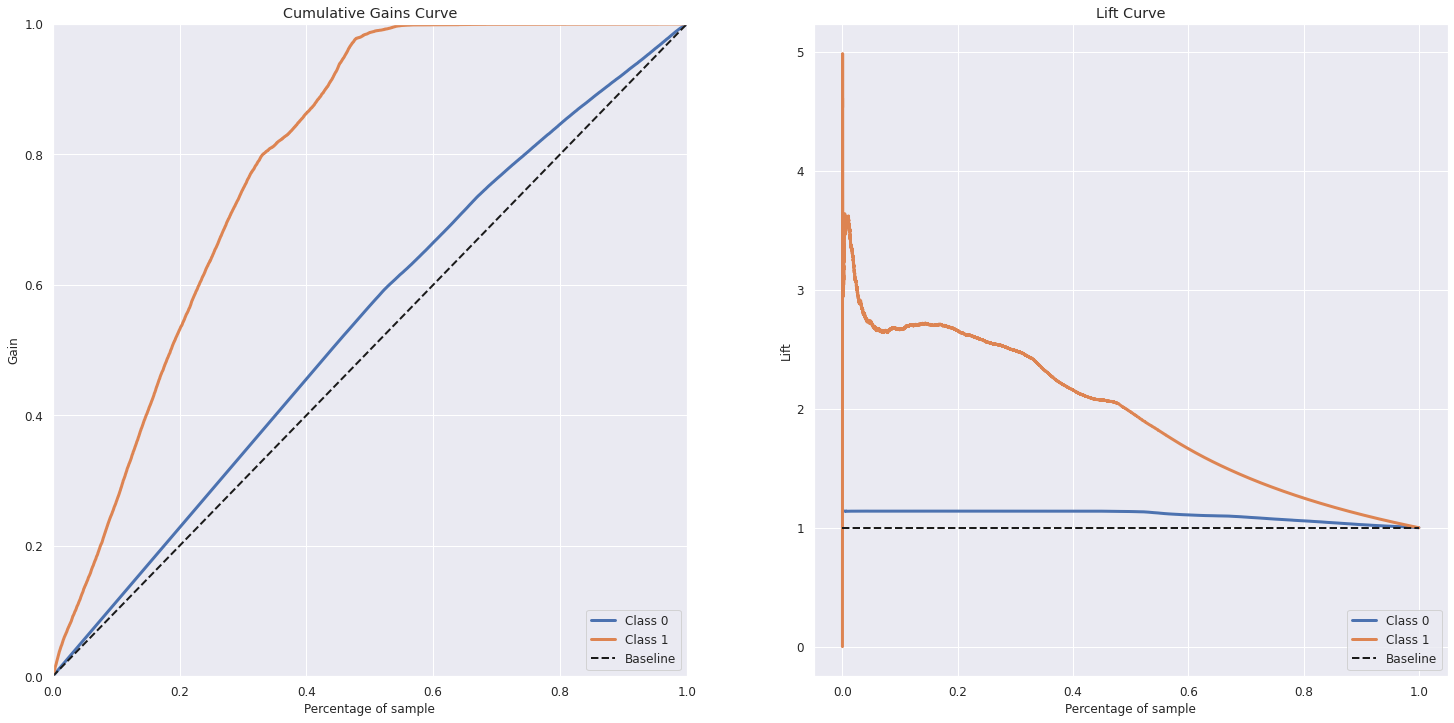

In [16]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_lm_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_lm_proba,ax=ax[1]);

## Random forrest classifier

In [17]:
rf_model = RandomForestClassifier(n_estimators=300,random_state=42,n_jobs=-1)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [18]:
#model prediction proba - poder de generalizção
yhat_rf_proba = rf_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_rf_class = rf_model.predict( x_val )

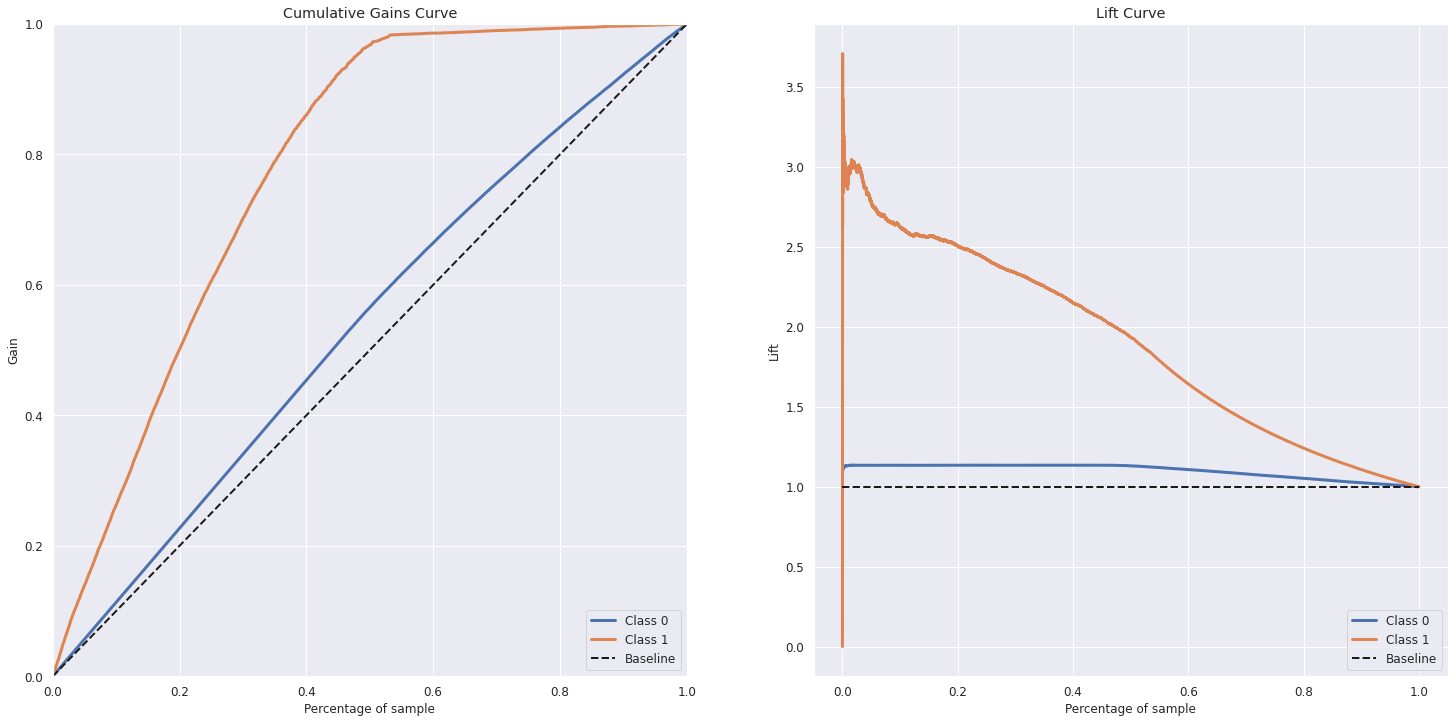

In [19]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_rf_proba,ax=ax[1]);

## Extratree classifier

In [ ]:
et_model = ExtraTreesClassifier(n_estimators=100,random_state=42,n_jobs=-1,max_depth=10)
et_model.fit(X_train,y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [21]:
#model prediction proba - poder de generalizção
yhat_et_proba = et_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_et_class = et_model.predict( x_val )

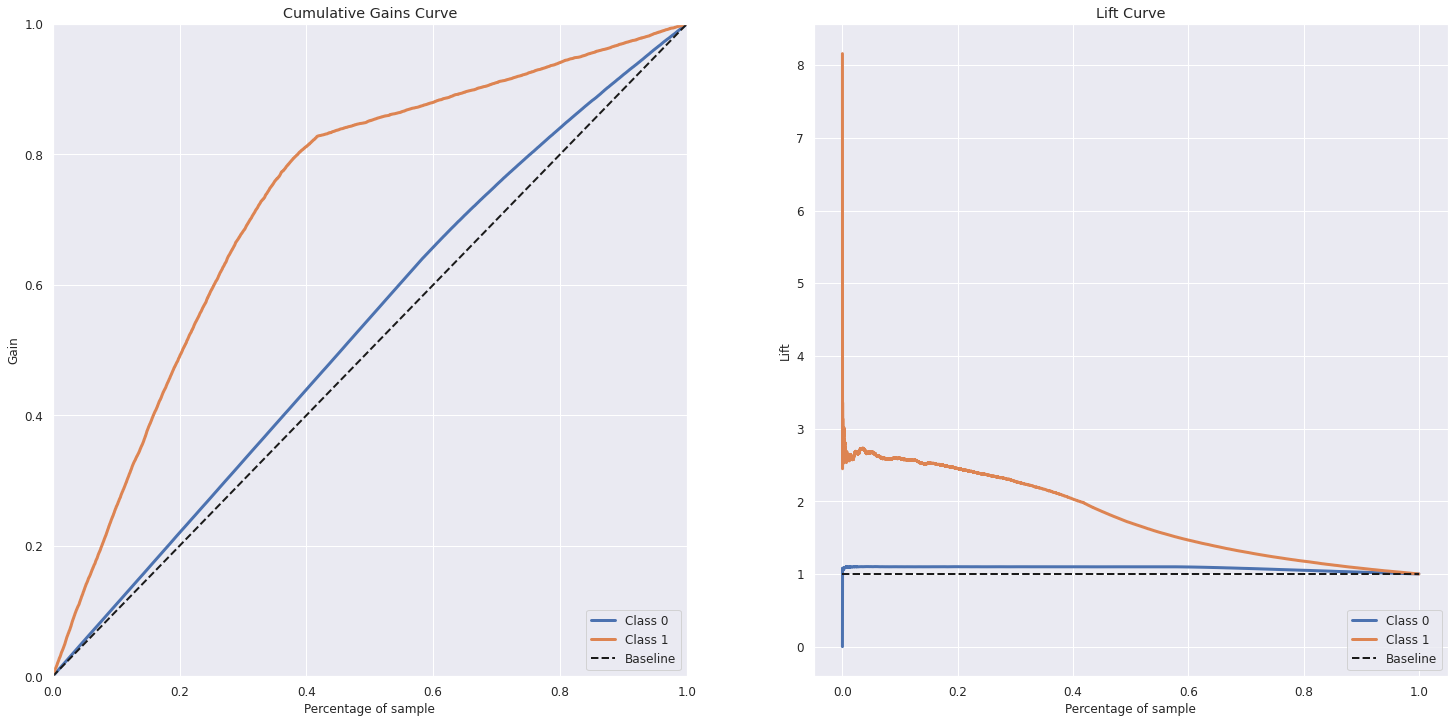

In [22]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_et_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_et_proba,ax=ax[1]);

## XGBoost

In [72]:
xgb_model = xgb.XGBClassifier(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X_train,y_train)

In [24]:
#model prediction proba - poder de generalizção
yhat_xgb_proba = xgb_model.predict_proba( x_val )

#model prediction - poder de generalizção
yhat_xgb_class = xgb_model.predict( x_val )

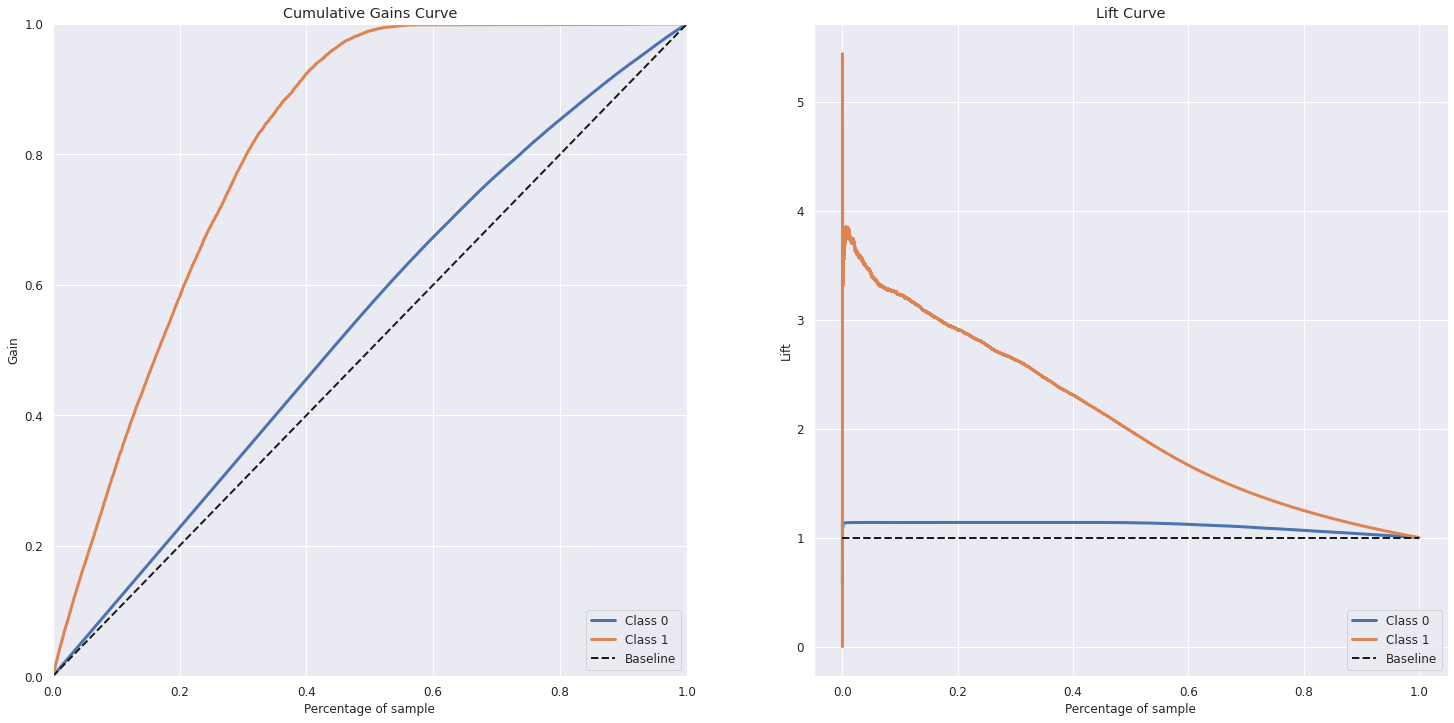

In [25]:
fig ,ax = plt.subplots(1,2)
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb_proba,ax=ax[0]);
skplt.metrics.plot_lift_curve(y_val,yhat_xgb_proba,ax=ax[1]);

# Model performace 

In [26]:
clients = 2000

## KNN

In [27]:
knn_df = val.copy()

In [28]:
knn_df['score_knn'] = yhat_knn_proba[:,1].tolist()
# sorte by score
knn_df = knn_df.sort_values('score_knn',ascending=False)

In [29]:
knn_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_knn
194783,194784,0.153846,43.0,155.0,0,0.778547,2,1,0,1.0
235906,235907,0.153846,33.0,124.0,0,0.058824,1,1,0,1.0
66091,66092,0.369231,28.0,26.0,0,0.944637,3,1,0,1.0
364418,364419,0.338462,30.0,124.0,0,0.826990,2,1,0,1.0
378903,378904,0.153846,3.0,124.0,0,0.190311,1,1,0,1.0


In [30]:
knn_performace = performace("KNN",knn_df,y_val,yhat_knn_class,clients)

In [31]:
knn_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,KNN,0.339061,0.178834,2000,0.356822,0.050953


## Linear model

In [32]:
lm_df = val.copy()

In [33]:
lm_df['score_lm'] = yhat_lm_proba[:,1].tolist()
# sorte by score
lm_df = lm_df.sort_values('score_lm',ascending=False)

In [34]:
lm_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_lm
205844,205845,0.169231,1.0,26.0,0,0.380623,3,1,0,0.536247
375383,375384,0.153846,9.0,31.0,0,0.782007,3,1,0,0.535942
334418,334419,0.184615,28.0,26.0,0,0.141869,3,1,0,0.529711
330638,330639,0.184615,28.0,26.0,0,0.432526,3,1,1,0.528954
91143,91144,0.184615,28.0,26.0,0,0.979239,3,1,0,0.527531


In [35]:
lm_performace = performace("linear model",lm_df,y_val,yhat_lm_class,clients)

In [36]:
lm_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,linear model,0.457627,0.001927,2000,0.404798,0.057803


## Randon forrest

In [37]:
rf_df = val.copy()

In [38]:
rf_df['score_rf'] = yhat_rf_proba[:,1].tolist()
# sorte by score
rf_df = rf_df.sort_values('score_rf',ascending=False)

In [39]:
rf_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_rf
106975,106976,0.153846,28.0,26.0,0,0.162630,1,1,0,0.996667
223683,223684,0.369231,28.0,26.0,0,0.851211,2,1,0,0.993988
72981,72982,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991248
184469,184470,0.384615,28.0,26.0,0,0.653979,2,1,0,0.991248
336024,336025,0.384615,28.0,26.0,0,0.653979,2,1,1,0.991248


In [40]:
rf_performace = performace("Random forest",rf_df,y_val,yhat_rf_class,clients)

In [41]:
rf_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Random forest,0.326515,0.208449,2000,0.368316,0.052594


## Extra trees

In [42]:
et_df = val.copy()

In [43]:
et_df['score_et'] = yhat_et_proba[:,1].tolist()
# sorte by score
et_df = et_df.sort_values('score_et',ascending=False)

In [44]:
et_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_et
44289,44290,0.246154,33.0,124.0,0,0.145329,2,1,0,1.0
183709,183710,0.400000,28.0,122.0,0,0.712803,2,1,0,1.0
100546,100547,0.230769,28.0,124.0,0,0.089965,2,1,1,1.0
325303,325304,0.338462,28.0,26.0,0,0.269896,2,1,1,1.0
56979,56980,0.476923,28.0,26.0,0,0.615917,3,1,0,1.0


In [45]:
et_performace = performace("Extra trees",et_df,y_val,yhat_et_class,clients)

In [46]:
et_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,Extra trees,0.316478,0.203668,2000,0.316842,0.045244


## XGboost

In [47]:
xgb_df = val.copy()

In [48]:
xgb_df['score_xgb'] = yhat_xgb_proba[:,1].tolist()
# sorte by score
xgb_df = xgb_df.sort_values('score_xgb',ascending=False)

In [49]:
xgb_df.head()

,id,age,region_code,policy_sales_channel,previously_insured,vintage,vehicle_age,vehicle_damage,response,score_xgb
324645,324646,0.092308,7.0,124.0,0,0.003460,1,1,0,0.674494
332801,332802,0.107692,7.0,124.0,0,0.003460,1,1,1,0.659958
61336,61337,0.461538,28.0,124.0,0,0.439446,1,1,1,0.645389
282873,282874,0.538462,41.0,26.0,0,0.702422,1,1,0,0.641053
15523,15524,0.553846,33.0,26.0,0,0.446367,1,1,1,0.628251


In [50]:
xgb_performace = performace("XGBoost",xgb_df,y_val,yhat_xgb_class,clients)

In [51]:
xgb_performace

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.44186,0.002712,2000,0.457771,0.065368


# Model comparrison

In [52]:
model_comp = pd.concat([knn_performace,lm_performace,rf_performace,et_performace,xgb_performace])

In [53]:
model_comp.sort_values('Precison at k',ascending=False)

,Model Name,Precison,Recall,k,Precison at k,Recall at k
0,XGBoost,0.441860,0.002712,2000,0.457771,0.065368
0,linear model,0.457627,0.001927,2000,0.404798,0.057803
0,Random forest,0.326515,0.208449,2000,0.368316,0.052594
0,KNN,0.339061,0.178834,2000,0.356822,0.050953
0,Extra trees,0.316478,0.203668,2000,0.316842,0.045244


# Croos validation

In [62]:
models = {
    'KNN': knn_model,
    'Linear model': lm_model,
    'Random forrest': rf_model,
    'Extra trees': et_model,
    'XGBoost':xgb_model
}

In [67]:
models_comparison = pd.DataFrame()

In [68]:
for c, v in models.items():
    aux = performace_cross_val(df6,'response',v,c)
    models_comparison = pd.concat([models_comparison,aux])

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/tmp/ipykernel_434/4150168656.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux[target] = y[test_index]
/tmp/ipykernel_434/4150168656.py:32: SettingWithCopyWarning: 
A value is trying to be se

In [71]:
models_comparison

,Model name,PRECISION CROSS_VAL,PRECISON STD,RECALL CROSS_VAL,RECALL STD,PRECISION AT K CROSS_VAL,PRECISION AT K STD,RECALL AT K CROSS_VAL,RECALL AT K STD
0,KNN Cross_Val,0.340,0.005,0.183,0.001,0.354,0.010,0.061,0.0
0,Linear model Cross_Val,0.384,0.082,0.001,0.001,0.374,0.007,0.064,0.0
0,Random forrest Cross_Val,0.324,0.001,0.205,0.001,0.347,0.008,0.059,0.0
0,Extra trees Cross_Val,0.316,0.003,0.203,0.001,0.312,0.003,0.053,0.0
0,XGBoost Cross_Val,0.502,0.017,0.003,0.000,0.458,0.010,0.079,0.0


In [78]:
xgb_model = xgb.XGBClassifier(objective='reg:squarederror',
                             n_estimators=700,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9)
xg_cross = performace_cross_val(df6,'response',xgb_model,'XGBoost')
xg_cross

,Model name,PRECISION CROSS_VAL,PRECISON STD,RECALL CROSS_VAL,RECALL STD,PRECISION AT K CROSS_VAL,PRECISION AT K STD,RECALL AT K CROSS_VAL,RECALL AT K STD
0,XGBoost Cross_Val,0.473,0.023,0.013,0.002,0.449,0.009,0.077,0.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3161d838-98a4-47ed-ae81-127ad2068af4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>